In [16]:
import torch
import torch.nn as nn
import torch.optim as optim

import numpy as np
import pandas as pd
import cv2
import os
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

In [3]:
label_number = {'0' : 0, '1' : 1, '2' : 2, '3' : 3, '4' : 4, '5' : 5, '6' : 6, '7' : 7, '8' : 8, '9' : 9, 'A' : 10, 'B' : 11, 'C' : 12, 'D' : 13, 'E' : 14, 'F' : 15, 'G' : 16, 'H' : 17, 'I' : 18, 'J' : 19, 'K' : 20, 'L' : 21, 'M' : 22, 'N' : 23, 'P' : 24, 'Q' : 25, 'R' : 26, 'S' : 27, 'T' : 28, 'U' : 29, 'V' : 30, 'W' : 31, 'X' : 32, 'Y' : 33, 'Z' : 34}
label_word = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']

In [13]:
def preprocess_image(image_path, img_size=(32, 128)):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  #load image in grayscale
    img = cv2.resize(img, img_size)  #resize to fixed size
    img = img.astype('float32') / 255.0  #normalize pixel values
    return img


transform = transforms.Compose([
    transforms.Grayscale(),  #convert to grayscale if needed
    transforms.Resize((32, 32)),  #resize all images to the same size
    transforms.ToTensor(),  #convert images to PyTorch tensors
    transforms.Normalize((0.5,), (0.5,))  #mormalize the images
])

dataset = ImageFolder(root='CNN letter Dataset', transform=transform)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)


In [62]:
print(dataset.classes) #What are our classes? (numbers and letters)
print(dataset.class_to_idx) #index for numbers and letters

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']
{'0': 0, '1': 1, '2': 2, '3': 3, '4': 4, '5': 5, '6': 6, '7': 7, '8': 8, '9': 9, 'A': 10, 'B': 11, 'C': 12, 'D': 13, 'E': 14, 'F': 15, 'G': 16, 'H': 17, 'I': 18, 'J': 19, 'K': 20, 'L': 21, 'M': 22, 'N': 23, 'P': 24, 'Q': 25, 'R': 26, 'S': 27, 'T': 28, 'U': 29, 'V': 30, 'W': 31, 'X': 32, 'Y': 33, 'Z': 34}


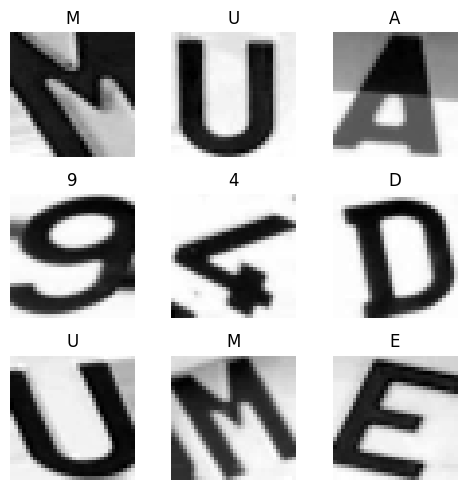

In [63]:
import matplotlib.pyplot as plt
import torchvision

#function to display some of our dataset to see which kind of images we have
def show_images_with_labels(images, labels, class_names):
    #create a 3x3 grid of images
    plt.figure(figsize=(5, 5))

    #set the number of rows and columns for the grid
    num_rows = 3
    num_cols = 3

    for i in range(min(len(images), num_rows * num_cols)):
        #compute the position of the image in the grid
        ax = plt.subplot(num_rows, num_cols, i + 1)
        
        #turn off the axes for aesthetic purposes
        ax.axis('off')
        
        #show the image
        img = images[i].permute(1, 2, 0)  #change the order of dimensions for displaying
        ax.imshow(img, cmap= "gray")
        
        #set the title to the label
        ax.set_title(class_names[labels[i].item()], color='black')  # Use .item() to convert tensor to scalar

    plt.tight_layout()
    plt.show()

#get a batch of data from the dataloader
images, labels = next(iter(dataloader))

#move the images and labels to CPU (if they are on GPU)
images = images.cpu()
labels = labels.cpu()

#show images with their labels
show_images_with_labels(images, labels, dataset.classes)


In [59]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim

class CNN_OCR(nn.Module):
    def __init__(self, num_classes=36):
        super(CNN_OCR, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=(22, 22), padding='same')
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(16, 16), padding='same')
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(8, 8), padding='same')
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(4, 4), padding='same')
        
        self.pool = nn.MaxPool2d(kernel_size=(4, 4))
        self.dropout = nn.Dropout(0.4)
        
        self.fc1 = nn.Linear(64 * 7 * 7, 128)  # Change based on input size and pooling
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        
        x = self.pool(x)  # Max pooling
        x = self.dropout(x)  # Dropout
        
        x = x.view(x.size(0), -1)  # Flatten the tensor
        
        x = F.relu(self.fc1(x))  # First fully connected layer
        x = self.fc2(x)  # Second fully connected layer
        return x

# Instantiate the model
num_classes = 36
model = CNN_OCR(num_classes=num_classes)

# Compile the model with a loss function and an optimizer
criterion = nn.CrossEntropyLoss()  # Use this for sparse categorical crossentropy
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Optionally, you can define your custom F1 score metric if needed
# Note: PyTorch does not have built-in metric tracking like Keras.


In [ ]:
# Assuming necessary imports and dataset loading
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Assuming CNN_OCR model from the previous section
num_classes = len(dataset.classes)  # Get number of unique classes (letters + numbers)
model = CNN_OCR(num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
epochs = 10
for epoch in range(epochs):
    model.train()
    epoch_loss = 0
    for images, labels in dataloader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()  # Reset gradients
        outputs = model(images)  # Forward pass through the network
        loss = criterion(outputs, labels)  # Calculate the loss

        loss.backward()  # Backpropagation to compute gradients
        optimizer.step()  # Update the weights

        epoch_loss += loss.item()

    print(f'Epoch [{epoch+1}/{epochs}], Loss: {epoch_loss/len(dataloader)}')


In [61]:
epochs = 10  # You can adjust the number of epochs
for epoch in range(epochs):
    model.train()  # Set the model to training mode
    epoch_loss = 0
    for images, labels in dataloader:
        images = images.to(device)  # Move images to the device
        labels = labels.to(device)  # Move labels to the device

        optimizer.zero_grad()  # Zero the gradients
        outputs = model(images)  # Forward pass
        loss = criterion(outputs, labels)  # Calculate loss
        loss.backward()  # Backward pass
        optimizer.step()  # Update weights

        epoch_loss += loss.item()  # Accumulate loss

    print(f'Epoch [{epoch+1}/{epochs}], Loss: {epoch_loss/len(dataloader):.4f}')

RuntimeError: Given groups=1, weight of size [16, 3, 22, 22], expected input[16, 1, 33, 33] to have 3 channels, but got 1 channels instead

In [ ]:
#inference

def predict(image_path, model):
    image = preprocess_image(image_path)  #preprocess the image
    image = image.unsqueeze(0).to(device)  #add batch dimension
    model.eval()  # Set model to evaluation mode

    with torch.no_grad():
        output = model(image)
        prediction = torch.argmax(output, dim=1)
    
    return prediction.item()

# Example usage
predicted_label = predict('test_image.png', model)
print(f'Predicted label: {predicted_label}')


In [55]:
# Initialize model
num_classes = 36  # Example: 26 letters + 10 digits
model = CNN_OCR(num_classes)

# Create a dummy input tensor with the shape (batch_size, channels, height, width)
dummy_input = torch.randn(16, 1, 28, 28)  # 16 samples, 1 channel (grayscale), 28x28 size
output = model(dummy_input)  # This will print the output shapes


Output shape before flattening: torch.Size([16, 32, 4, 4])
Output shape after flattening: torch.Size([16, 512])
